The code presented here was assembled and adapted from PyMC documentation and examples.  
DOI:  10.5281/zenodo.4058330
The most relevant example notebook is:
"ODE Lotka-Volterra With Bayesian Inference in Multiple Ways"
https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#summary

I also adapted some code portions of "Approximate Bayesian Computation" though that technique isn't quite what we are actually using.
https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html

Here is some preamble material for loading apparently necessary packages.  You don't need to modify this.  Executing this fragment should verify whether it found the python kernel to execute commands.  Note this notebook assumes pymc and numba have been installed.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")
from pytensor.compile.ops import as_op
from scipy.integrate import odeint

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.1


Here the kinetic model is defined.  You will want to update this section with the parameters and differential equations of your model.

In [4]:
# Definition of true model parameters:

# Proportion of scraps available to cat popoulation
S_1 = 1

# Proportion of scraps available to rat population
S_0 = 1

# Contribution of each succesful cat-prey interaction to cat population
gamma = 1

# Contribution of each succesful rat-prey interaction to rat population
gamma_R = 1

# Predation rate for Cat-Bird interactions
mu_B = 1

# Predation rate for Cat-Rat interactions
mu_R = 1

# Predation rate for Rat-Bird interactions
eta_B = 1

# Per-capita rate of Feral, Rat & Bird reproductive rates
r_F = 1
r_R = 1
r_B = 1

# Average lifespan of a stray cat
T_S = 1

# Lifespan increase by TNR to an individual cat
v_Plus = 1

# Ratio between T_S and artificially shortened life span of strays
alpha = 1

# Average rate at whcih TNR programs are conducted
rho = 1

# initial values.  
F_in = 1
N_in = 1
R_in = 1
B_in = 1

# number of time points
ntimes = 100
# range of time
time_end = 21

# This gives "ntimes" equally spaced points of time between the first and second argument
times = np.linspace(0, time_end, ntimes)

# seems we need to list all the parameters and initial variables into a single vector.  
# I ran into problems with pytensor when trying to separate out the initial conditions for
# the variables, which would be more natural.  Make sure to put the initial variables last, in
# the same order as you put the state variables.
theta=np.array([S_1, S_0, gamma, gamma_R, mu_B, mu_R, eta_B, r_F, r_R, r_B, T_S, v_Plus, alpha, rho, F_in, N_in, R_in, B_in])

from numba import njit
@njit # I really don't know what this tweet at NJIT is supposed to do, might be some 
# performance enhancement.  Their math dept is now 3 times as large as ours so...?
# Defines the rates of change of each state variable
def dX_dt(X, t, theta):
    F,N,B,R=X # unpack the variables from the superstate vector X, otherwise refer to states as X[0],X[1], etc.
    S_1, S_0, gamma, gamma_R, mu_B, mu_R, eta_B, r_F, r_R, r_B, T_S, v_Plus, alpha, rho, F_in, N_in, R_in, B_in=theta # unpack the superparameter vector theta
    
    Ft = F * ( gamma * ( mu_B * B + mu_R * R )/(S_1 + B + R) + r_F - alpha / T_S)-rho
    Nt = rho - N / (v_Plus * T_S)
    Rt = R * ( -mu_R * (F + N) / (S_1 + B + R) + gamma_R * eta_B * B / (S_0 + B) + r_R ) 
    Bt = B * ( -mu_B * (F + N) / (S_1 + B + R) - eta_B * R / (S_0 + B) + r_B)
        
    return np.array([Ft, Nt, Rt, Bt])

Here is some code that just populates statevalues with the output of a simulation, so you can plot or examine it.  Set nstatevars to the number of state variables you have.

In [5]:
nstatevars = 4 
statevalues = odeint(func=dX_dt, y0=theta[-nstatevars:], t=times, args=(theta,))

Here is some code to generate plots of real or synthetic time series data, or outputs of your model.  Whatever it is you are trying to plot is what should replace or be equated to statevalues[:,:], where the first argument indices the times and the second argument indexes your state variables.  This example code has 2 state values (prey and predator), and following the time-honored convention of computer science, starts counting from 0.  The text labels should be modified in the obvious ways for your model.  The last line saves the figure so you can import it into your document without taking a screenshot.  Apparently python is smart enough to interpret various file types?

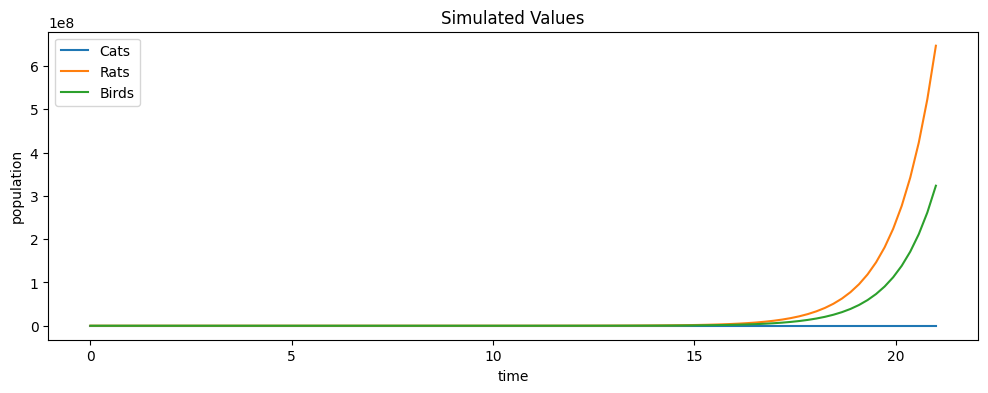

In [9]:
# plotting simulations or data
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(times,statevalues[:, 0] + statevalues[:, 1], "-", label="Cats")
ax.plot(times,statevalues[:, 2], "-", label="Rats")
ax.plot(times,statevalues[:, 3], "-", label="Birds")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Simulated Values")
ax.legend();
plt.savefig('simulationfile.png')

Now we add observational noise.  Using unbiased normal distributions for observational noise is standard, though you might modify it if you are getting negative observations for quantities that should be non-negative.  Or you might want to incorporate bias in observations.  In any case, choose reasonable magnitudes for the observational error, which you set in the first few lines

In [25]:
# List the error magnitudes (standard deviations) of each state variable
# For unobserved state variables, the value chosen doesn't matter
# Copy the names into noise_mat below
sdobs_rabbit=10
sdobs_fox=3

# List the observational biases and copy the names into bias_mat below
bias_rabbit=-10
bias_fox=0

# have to list the bias and sdobs parameters in the list bias_mat and noise_mat
bias_mat=np.diagflat([bias_rabbit,bias_fox])
bias=np.matmul(np.ones(statevalues.shape),bias_mat)

noise_mat=np.diagflat([sdobs_rabbit,sdobs_fox])
noise = np.matmul(np.random.normal(size=(ntimes, nstatevars)),noise_mat) 

# the maximum function can be dropped if we want to allow negative observations
synthetic_data = np.maximum(np.zeros(statevalues.shape),statevalues + bias+noise)
# this will be the fake observed data to be used for parameter inference. 
# Data is also generated for unobserved variables but will not be used.
# It is obtained by running the true model with the true values of the parameters and adding observational noise.

So now let's see what the synthetically observed data looks like.  Use the same plotting function as above but now with the synthetic_data rather than the true simulated values.

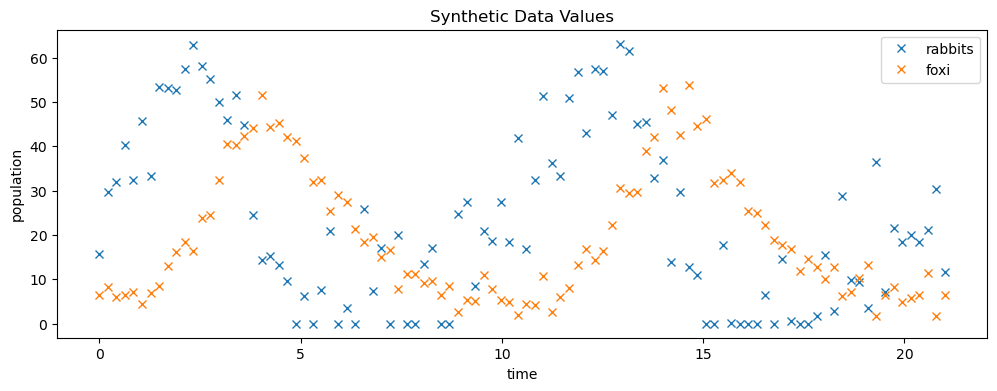

In [26]:
# plotting the synthetically observed data
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(times,synthetic_data[:, 0], "x", label="rabbits")
ax.plot(times,synthetic_data[:, 1], "x", label="foxi")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Synthetic Data Values")
ax.legend();
plt.savefig('datafile.png')

Next you specify your prior belief in the model parameters.  You can change "model_of_what" to a name reflective your model.  Then, starting with the line after "with pm.Model()" line list all parameters with "known" parameters set to their confidentally believed values (which may or may not be correct) and uncertain parameters set to a random variable with a prescribed prior probability distribution.  (For this class, we can treat the prior uncertainty across parameters as independent, though this isn't mathematically necessary.)  You can find choices of probability distributions, and how they should be parameterized, for your prior at https://www.pymc.io/projects/docs/en/stable/api/distributions.html

In [27]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=dX_dt, y0=theta[-nstatevars:], t=times, args=(theta,)) 

with pm.Model() as model_of_what:
    a = pm.HalfNormal("a",1.0)
    b = 0.026
    c= 0.84
    d= pm.TruncatedNormal('d', mu=1, sigma=0.2, lower=0)
    rabbit_init=34
    fox_init=5.9
# The known values could be the same as the true values, or they could be misspecified 
    # (confident belief is not true). But then copy the incorrect beliefs into 
    # model_of_uncertain_pars below
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([a, b, c, d, rabbit_init,fox_init]) # copy your list of parameters here
    )
    trace_prior=pm.sample_prior_predictive(samples=600) # samples from prior distribution


    # Now apply the following line for each population that is actually observed.
    # You will change the last index of ode_solution and synthetic_data to the index of the 
    # population being observed.  The sigma should be changed to the standard deviation of
    # the observational noise (unless you want to consider that as misspecified)
    # Bias could also be included in mu if the data scientist is aware of the bias
    # Again, you could list multiple lines for multiple observed populations
    pm.Normal("rabbit_obs", mu=ode_solution[:,0]-10, sigma=sdobs_rabbit, observed=synthetic_data[:,0])
    pm.Normal("fox_obs", mu=ode_solution[:,1], sigma=sdobs_fox, observed=synthetic_data[:,1])

Sampling: [a, d]


Now that the everything has been specified about the statistical inputs and assumptions, we now want to see what kind of uncertainty our model has for prediction, both on its own (prior distribution of parameters) and incorporating the observational data (posterior distribution of parameters).

In this next block of code, one needs to choose the time range of prediction, which should be longer than the time range of observation in practice.

In [28]:
# number of time points
ntimes_pred = 100
# time to predict up to
time_pred_end = 40
# This gives "ntimes" equally spaced points of time between the first and second argument
times_pred = np.linspace(0, time_pred_end, ntimes_pred)
# Now we run the ground truth model over this prediction range to compare against the statistical predictions
statevalues_pred = odeint(func=dX_dt, y0=theta[-nstatevars:], t=times_pred, args=(theta,))

Change the arguments of the next function to your uncertain parameters.  This function just allows those uncertain parameters to be varied over randomly sampled values with the other parameters held fixed.  By default, the fixed parameters are set to their true values.  If you wish the "known" parameters to be misspecified, then change their values manually within this definition, after the line defining theta.

In [29]:
def model_of_uncertain_pars(a,d):
    theta=np.array([a,b,c,d,rabbit_init,fox_init])
    return odeint(func=dX_dt, y0=theta[-nstatevars:], t=times_pred, args=(theta,)) 

Now we plot our uncertainty about the model predictions based on prior beliefs, absent the data.  The first set of plotting commands shows the true behavior at the times to be predicted as a heavy line.  The next set of commands give the average prediction from the prior statistical model as a dashed line.  Finally, simulations of the model for a random selection of the parameters give a visualization of the uncertainty in the predictions of the prior model.

You might choose not to plot all the state variables if doing so makes the plot too messy.

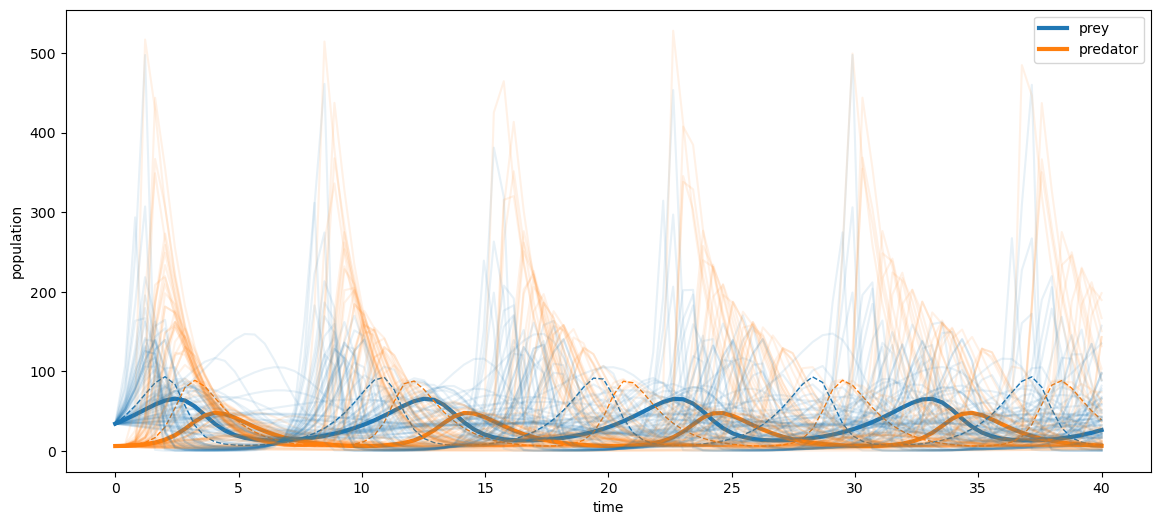

In [30]:
_, ax = plt.subplots(figsize=(14, 6))
prior = trace_prior.prior.stack(samples=("draw", "chain"))
ax.plot(times_pred,statevalues_pred[:, 0], label="prey", c="C0", mec="k",linewidth=3)
ax.plot(times_pred,statevalues_pred[:, 1], label="predator", c="C1", mec="k",linewidth=3)
mean_predictions=model_of_uncertain_pars(prior["a"].mean(), prior["d"].mean())
ax.plot(times_pred,mean_predictions[:, 0], '--',  c="C0", mec="k",linewidth=1)
ax.plot(times_pred,mean_predictions[:, 1], '--',  c="C1", mec="k",linewidth=1)
for i in np.random.randint(0, prior["a"].size, 75):
    sim = model_of_uncertain_pars(prior["a"][i], prior["d"][i])
    ax.plot(times_pred,sim[:, 0], alpha=0.1, c="C0")
    ax.plot(times_pred,sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();
plt.savefig('priorfile.png')

Now we generate random samples from the data-informed posterior model using some version of the Metropolis algorithm.  You need to change the negative integer in the vars_list line to be the negative number of state variables that are observed.  You can freely experiment with changing the values of "draws," "chains," and "cores."  Be aware that running pymc on more than one core on windows machine tends to have reported problems.

In [31]:
# Variable list to give to the sample step parameter
vars_list = list(model_of_what.values_to_rvs.keys())[:-2]
sampler = "DEMetropolis" # can try DEMetropolisZ or DEMetropolis
with model_of_what:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)], draws=600, chains=4,cores=1)
trace = trace_DEM

Population sampling (4 chains)
DEMetropolis: [a, d]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.


C:\ProgramData\miniforge3\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 1_000 tune and 600 draw iterations (4_000 + 2_400 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The next command presents a summary of the inferred posterior distribution of the uncertain model parameters.  The first column gives the mean (expected value).  The second column gives the standard deviation of the posterior distribution (uncertainty magnitude).  The third and fourth columns give the 3% and 97% quantile cutoffs.

In [32]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.518,0.004,0.510,0.526,0.000,0.000,183.0,208.0,1.02
d,1.003,0.014,0.974,1.028,0.001,0.001,140.0,248.0,1.03


This next command should plot the posterior distributions graphically.  It is not working for me because of a file permission error but it might work for you. It would be mostly useful for when the parameters are badly estimated -- you can visualize a bit better what is happening to the inference.  Remove the "#" to make this command active.

In [63]:
#az.plot_posterior(trace)

And now plotting our state trajectory predictions under the posterior distribution.  This is done in the same way as the predictions under the prior distribution, except the observation data is also shown.

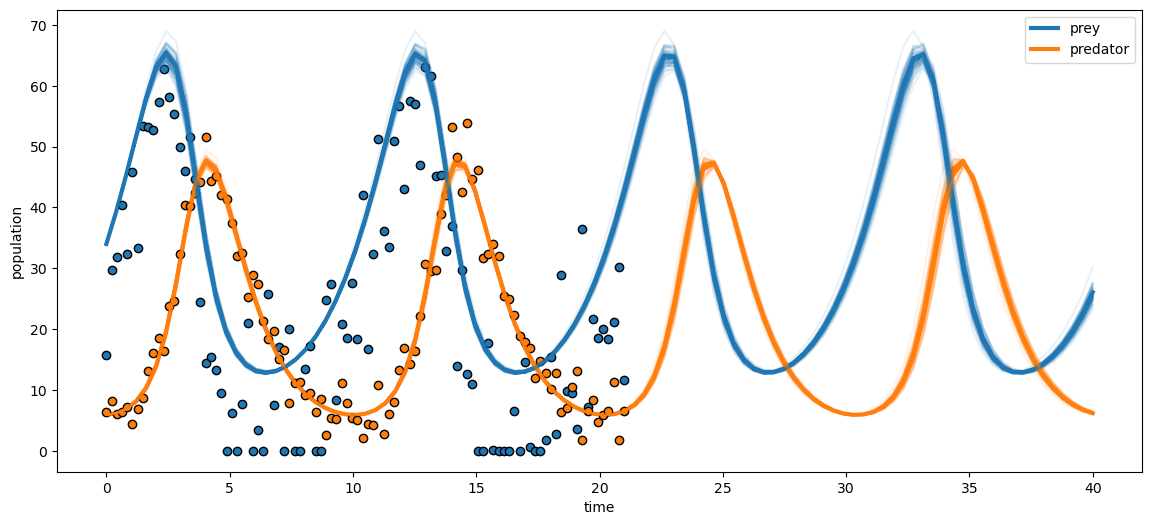

In [33]:
#plot posterior distribution of state trajectories
_, ax = plt.subplots(figsize=(14, 6))
posterior = trace.posterior.stack(samples=("draw", "chain"))
ax.plot(times_pred,statevalues_pred[:, 0], label="prey", c="C0", mec="k",linewidth=3)
ax.plot(times_pred,statevalues_pred[:, 1], label="predator", c="C1", mec="k",linewidth=3)
ax.plot(times,synthetic_data[:, 0], "o", c="C0", mec="k")
ax.plot(times,synthetic_data[:, 1], "o", c="C1", mec="k")
mean_predictions=model_of_uncertain_pars(posterior["a"].mean(), posterior["d"].mean())
ax.plot(times_pred,mean_predictions[:, 0], '--',  c="C0", mec="k",linewidth=1)
ax.plot(times_pred,mean_predictions[:, 1], '--',  c="C1", mec="k",linewidth=1)
for i in np.random.randint(0, posterior["a"].size, 75):
    sim = model_of_uncertain_pars(posterior["a"][i], posterior["d"][i])
    ax.plot(times_pred,sim[:, 0], alpha=0.1, c="C0")
    ax.plot(times_pred,sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();
plt.savefig('posteriorfile.png')